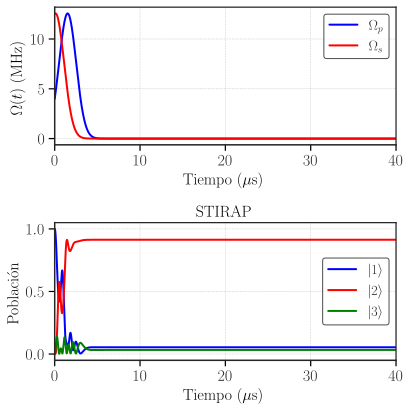

Valor final población |1>: 0.0540
Valor final población |2>: 0.9133
Valor final población |3>: 0.0327
Tiempo para llegar al 99% del valor máximo de p2: 1.3921 μs
Tiempo total de la simulación: 2.1307 segundos


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import matplotlib as mpl
from matplotlib import rcParams
from scipy.integrate import odeint
import time  
import seaborn as sns


def initialize_plotting(style='whitegrid'):
    import IPython
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import seaborn as sns
 
    # Aplicar el estilo de Seaborn
    sns.set(style=style)

    # Estilos para gráficos
    label_size = 20
    mpl.rcParams['xtick.labelsize'] = label_size 
    mpl.rcParams['ytick.labelsize'] = label_size 
    plt.rc('font', family='serif')  # Fuente serif para el texto
    
    # figuras alta calidad jupyter
    %config InlineBackend.figure_format = 'svg' 
    
    mpl.rcParams.update({'font.size': 16})
    mpl.rcParams['text.usetex'] = True   
    
# Inicializamos el contador de tiempo
start_time = time.time()  

# Inicializamos los parámetros para el gráfico
initialize_plotting('ticks')

# Parámetros del modelo
Delta1 = 2 * np.pi * 0.2
Delta2 = Delta1
delta = Delta1 - Delta2

# Tasas de decaimiento
gamma1 = 1e-3
gamma2 = gamma1
gamma3 = 0.1

# Pulsos gaussianos
Omega13 = 2 * np.pi * 2
Omega23 = 2 * np.pi * 2
sigma = 1
ts = 0.1
td = np.sqrt(2) * sigma
tp = ts+td

# Definimos la base para el sistema de tres niveles
ket1 = basis(3, 0)  # |1>
ket2 = basis(3, 1)  # |2>
ket3 = basis(3, 2)  # |3>

# Operadores sigma_ij = |i><j|
sigma_11 = ket1 * ket1.dag()  # |1><1|
sigma_22 = ket2 * ket2.dag()  # |2><2|
sigma_33 = ket3 * ket3.dag()  # |3><3|
sigma_31 = ket3 * ket1.dag()  # |3><1|
sigma_13 = ket1 * ket3.dag()  # |1><3|
sigma_32 = ket3 * ket2.dag()  # |3><2|
sigma_23 = ket2 * ket3.dag()  # |2><3|

# Definimos el arreglo para el tiempo y los parámetros de control
tlist = np.linspace(0, 40, 10000)
args = {'tp': tp, 'ts': ts, 'width': sigma}  # Peak time and width of the Gaussian pulses

# Definimos los controles como funciones que dependen del tiempo
Omega_p = lambda t, args: Omega13*np.exp(-0.5*((t - args['tp']) / args['width']) ** 2)  # Pump pulse
Omega_s = lambda t, args: Omega23*np.exp(-0.5*((t - args['ts']) / args['width']) ** 2)  # Stokes pulse

# Calculate the values of the control functions over the time array
Omega_p_values = [Omega_p(t, args) for t in tlist]
Omega_s_values = [Omega_s(t, args) for t in tlist]


# Definimos cada componente del Hamiltoniano
H0 = delta*sigma_22 + Delta1*sigma_33
Hp = (sigma_31+sigma_13)/2  # Acoplamiento para |1> <--> |3>, Omega_p
Hs = (sigma_32+sigma_23)/2  # Acoplamiento para |2> <--> |3>, Omega_s

# Hamiltoniano total dependiente del tiempo
H = [H0, [Hp, Omega_p], [Hs, Omega_s]]

# Operadores de colapso con sus respectivas tasas de decaimiento
c_ops = [
    np.sqrt(gamma1) * sigma_11,  # Colapso para |1>
    np.sqrt(gamma2) * sigma_22,  # Colapso para |2>
    np.sqrt(gamma3) * sigma_33   # Colapso para |3>
]

# Estado inicial |1>
psi0 = ket1  # Starting in state |1>

# Resolvemos la ecuación maestra usando mesolve
result = mesolve(H, psi0, tlist, c_ops, [basis(3, 0).proj(), basis(3, 1).proj(), basis(3, 2).proj()], args=args)
p1 = np.abs(result.expect[0])
p2 = np.abs(result.expect[1])
p3 = np.abs(result.expect[2])

# Crear figura y ejes para ambos gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), tight_layout=True)

# Primer gráfico: Campos de control
ax1.plot(tlist, Omega_p_values, label=r"$\Omega_p$", color='blue', linewidth=2)
ax1.plot(tlist, Omega_s_values, label=r"$\Omega_s$", color='red', linewidth=2)
ax1.set_xlabel("Tiempo ($\mu$s)", fontsize=16, color='black')
ax1.set_ylabel("$\Omega(t)$ (MHz)", fontsize=16, color='black')
ax1.legend(loc='best', fontsize=14, frameon=True, framealpha=0.7, edgecolor='black')
ax1.set_xlim([min(tlist), max(tlist)])
ax1.tick_params(axis='both', which='major', labelsize=16, color='black')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.spines['left'].set_linewidth(1.5)
ax1.spines['bottom'].set_linewidth(1.5)

# Segundo gráfico: Poblaciones
ax2.plot(tlist, p1, label=r"$|1\rangle$", color='blue', linewidth=2)
ax2.plot(tlist, p2, label=r"$|2\rangle$", color='red', linewidth=2)
ax2.plot(tlist, p3, label=r"$|3\rangle$", color='green', linewidth=2)
ax2.set_xlabel("Tiempo ($\mu$s)", fontsize=16, color='black')
ax2.set_ylabel("Población", fontsize=16, color='black')
ax2.legend(loc='best', fontsize=14, frameon=True, framealpha=0.7, edgecolor='black')
ax2.set_xlim([min(tlist), max(tlist)])
ax2.tick_params(axis='both', which='major', labelsize=16, color='black')
ax2.set_title('STIRAP', fontsize=16, color='black')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.spines['left'].set_linewidth(1.5)
ax2.spines['bottom'].set_linewidth(1.5)

# Mostrar los gráficos
plt.show()

# Imprimir los valores finales de cada población
print(f"Valor final población |1>: {p1[-1]:.4f}")
print(f"Valor final población |2>: {p2[-1]:.4f}")
print(f"Valor final población |3>: {p3[-1]:.4f}")

# Calcular el tiempo para llegar al 99% del valor máximo de p2
p2_max = np.max(p2)
threshold = 0.99 * p2_max
time_to_reach_threshold = tlist[np.where(p2 >= threshold)[0][0]]
print(f"Tiempo para llegar al 99% del valor máximo de p2: {time_to_reach_threshold:.4f} μs")

# Detener el temporizador
end_time = time.time()  
simulation_time = end_time - start_time
print(f"Tiempo total de la simulación: {simulation_time:.4f} segundos")